In [1]:
import torch  # type: ignore
import pyro  # type: ignore (to install it please use %pip install pyro-ppl )
import pyro.distributions as dist  # type: ignore
from pyro.optim import Adam  # type: ignore
from pyro.infer import SVI, Trace_ELBO  # type: ignore
from pyro.infer import MCMC, NUTS, HMC  # type: ignore
from torch.distributions import constraints  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import seaborn as sns  # type: ignore
import scipy  # type: ignore
import numpy as np  # type: ignore
import tqdm  # type: ignore
import pyro.poutine as poutine  # type: ignore



# Introduction
Consider a problem in which we have a parameter $\theta$ that we do not directly measure, but we have indirect measures, for instance: $x=f(\theta)+\varepsilon$.

This model, given the distribution of the noise $\varepsilon$ and the prior on $\theta$, gives us the possibility to reconstruct the posterior distribution of the latent variable: $p(\theta\mid x)$.

However we have some problems, indeed we are not alwayse able to compute the exact posterior distribution: $$p(\theta\mid x) = \frac{p(x\mid \theta)p(\theta)}{\int p(x\mid \theta)p(\theta) d\theta}$$ especially the integral denominator is the big problem.
For this reason we can 1) simplify the model in order to obtain a closed form solution for the psterior distribution (eg conjugate prior); 2) be happy with an approximate solution.
Using a great sentence of John Tukey "Far better an approximate answer to the right question, which is often vague, than an exact answer to the wrong question, which can always be made precise", we can justificate the usage of an approximate method.

# Variational Inference (VI)

Variational inference describes a methodology to perform approximate inference. With VI we  consider a space of surrogate functions $\mathcal{Q}$ where our approximated posterior distribution $q(\theta\mid x)$ belongs to. To compute the optimal approximated posteriot we minimise the dissimilarity between the approximation  and the actual posterior that we cannot compute in close form. There are two things we have to fix before continuing: 1) th enotion of dissimilarity to use; 2) the space of functions.

1. as notion of dissimilarity we consider the Kullback-Leibler (KL) divergence, that measures the (statistical) discrepancy between two probability distributions:

$$D_{KL}(q\|p) = \int q(\theta ) \ln\left(\frac{q(\theta)}{p(\theta\mid x)}\right) d\theta$$

2. for simplicity we consider parametric inference, it means that we fix the family of distributions $\mathcal{Q}$ and we optimise w.r.t. the parameters $\theta$ of these distributions (eg. mean and std for Gaussian family of distributions).

Therefore a variational inference method looks for the optimal distribution: $q^*(\theta) = \arg\min_{q\in\mathcal{Q}} D_{KL}(q\|p)$.

Unfortunately, the $D_{KL}$ often does not have a closed form solution, therefore we have to evaluate it in some other way. We can expand it obtaining:

$$D_{KL}(q\|p) = \int q(\theta) \ln\left(\frac{q(\theta)}{p(\theta\mid x)}\right) d\theta = 
\int q(\theta) \ln\left(\frac{q(\theta)}{p(\theta,x)}\right) d\theta + \ln(p(x))\int q(\theta)d\theta =-\underbrace{\mathbb{E}_{q}\left[\ln\left(\frac{p(\theta,x)}{q(\theta)}\right)\right]}_{\text{ELBO}(q)} +\ln(p(x))$$


Therefore we have that the $D_{KL}$ is the difference between the data evidence $\ln(p(x))$ and the ELBO ${\mathbb{E}_{q}\left[\ln\left(\frac{p(\theta,x)}{q(\theta)}\right)\right]}$. 
Since the $D_{KL}$ is always positive and the data evidence $\ln(p(x))$ does not depend from $q(\theta)$, the above equation implies that the maximisation of the ELBO corresponds to the minimization of the $D_{KL}$ between approximated and target posterior:

$$q^*(\theta) = \arg\min_{q\in\mathcal{Q}} D_{KL}(q\|p)=\arg\max_{q\in\mathcal{Q}} \text{ELBO}(q).$$


An alternative approach to derive the ELBO can be obtained starting from the evidence:

$$ \ln(p(x)) = \ln \int_\theta p(x,\theta) d\theta  = \ln \int_\theta p(x,\theta)\frac{q(\theta)}{q(\theta)} d\theta = \ln  \mathbb{E}_{q}\frac{p(x,\theta)}{q(\theta)} \geq  \mathbb{E}_{q} \left[\ln \left(\frac{p(x,\theta)}{q(\theta)}\right)\right] = ELBO$$.

This inequality shows that the ELBO is a lower bound to the data evidence. As seen above, the gap between the two is precisely $D_{KL}(q\|p)$.  


But, how can we optimise the ELBO? Via **Gradient descent** for example. Of curse it is not easy to implement a code that does everithing we need. But it is easy thanks to some tools, such as Pyro.


## Optimizing the ELBO

Optimizing the ELBO requires to solve the problem:

$$q^*(\theta) = \arg\max_{q\in\mathcal{Q}} \text{ELBO}(q) = \arg\max_{q\in\mathcal{Q}} \mathbb{E}_{q} \left[\ln \left(\frac{p(x,\theta)}{q(\theta)}\right)\right] = \arg\max_{q\in\mathcal{Q}} \mathbb{E}_{q} \left[\ln p(x,\theta) - \ln q(\theta)\right].$$

In particular, from now on the target model $p(x,\theta)$ and the variational posterior $q(\theta)$ will be parameterized by respectively $\psi$ and $\phi$, i.e.:

$$p(x,\theta) = p_\psi(x,\theta),$$
$$q(\theta) = q_\phi(\theta).$$

Optimizing the ELBO via gradient descent thus requires computing:

$$\nabla_{\psi, \phi} ELBO = \nabla_{\psi, \phi} \mathbb{E}_{q_\phi(\theta)} \left[\ln p_\psi(x,\theta) - \ln q_\phi(\theta)\right].$$

How to do that in practice? 

### The simple case: a sample from $q_\phi(\theta)$ is parameterized by a simpler known distribution.

This is the case for Gaussian approximations $q_\phi(\theta) = N(\mu,\sigma^2)$ and $\phi = (\mu, \sigma)$. A sample $\theta' \sim q_\phi(\theta)$ can be written as $\theta' = g_\phi(\epsilon) = \mu + \epsilon \sigma$, where $\epsilon\sim N(0,1)$.

In this case, any function of the form $\mathbb{E}_{q_\phi(\theta)} f_\phi(\theta)$ can be rewritten as 

$$\mathbb{E}_{q_\phi(\theta)} f_\phi(\theta) = \mathbb{E}_{q(\epsilon)} (f_\phi(g_\phi(\epsilon))$$

and the gradient can be simply computed as 

$$\nabla_\phi  \mathbb{E}_{q_\phi(\theta)} f_\phi(\theta) = \mathbb{E}_{q_\epsilon} \nabla_\phi (f_\phi(g_\phi(\epsilon)).$$

This gradient is simple to compute by chain rule, and the expectation can be approximated by Monte Carlo sampling.


### The difficult case: a sample from $q_\phi(\theta)$ is non parameterizable

In this case we need to do some math to obtain a suitable form for the estimation of the gradients $\nabla_\phi  \mathbb{E}_{q_\phi(\theta)} f_\phi(\theta).$

We go back to the expectation:

$$\nabla_\phi  \mathbb{E}_{q_\phi(\theta)} f_\phi(\theta) = \nabla_\phi  \int_\theta q_\phi(\theta) f_\phi(\theta) d\theta $$

and we apply the chain rule:

$$\nabla_\phi  \int_\theta q_\phi(\theta) f_\phi(\theta) d\theta =   \int_\theta \nabla_\phi \left(q_\phi(\theta)\right) f_\phi(\theta) + q_\phi(\theta) \left(\nabla_\phi f_\phi(\theta) \right)d\theta $$

We can easily handle the second term, since computing the expectation simply requires to Monte Carlo sampling of $q_\phi(\theta)$ to weight the gradients $\nabla_\phi f_\phi(\theta)$, which we are able to compute (for example by backpropagation).

The problem is in the first term, since we don't know how to compute the gradients of the samples $\nabla_\phi q_\phi(\theta)$. We can resort to the chain rule to write the problem in a nicer form:

$$ \nabla_\phi q_\phi(\theta) = q_\phi(\theta) \nabla_\phi \ln(q_\phi(\theta)).$$

This time, the gradient $\nabla_\phi \ln(q_\phi(\theta))$ can be computed in close form and this latter quantity can be computed again by Monte Carlo sampling.

Overall, the gradient will be obtained as:

$$ \nabla_\phi \mathbb{E}_{q_\phi(\theta)} f_\phi(\theta) = \mathbb{E}_{q_\phi(\theta)} \left[ \left(\nabla_\phi \ln(q_\phi(\theta))\right) f_\phi(\theta)  + \left(\nabla_\phi f_\phi(\theta)\right) \right]$$



# Pyro (Simple way to make inference)

Pyro is an open-source probabilistic programming language developed by Uber AI Labs, designed to seamlessly integrate deep learning with probabilistic modeling. Built on top of PyTorch, Pyro offers a powerful framework for constructing and evaluating complex probabilistic models. One of Pyro's core strengths lies in its support for variational inference, a method used to approximate intractable posterior distributions in Bayesian inference.

Variational inference in Pyro allows users to estimate the posterior distribution of latent variables by optimizing a simpler, parameterized distribution to be as close as possible to the true posterior. This is achieved by minimizing the Kullback-Leibler (KL) divergence between the approximate and true distributions. Pyro provides a range of tools and abstractions to facilitate this process, making it easier to handle large-scale models and datasets.

Pyro’s flexible and modular design supports various inference algorithms, including Stochastic Variational Inference (SVI), enabling users to perform inference in high-dimensional and non-conjugate models efficiently. By leveraging PyTorch’s automatic differentiation and GPU acceleration, Pyro ensures that the implementation of variational inference is both efficient and scalable.

Whether you are working on complex hierarchical models, deep generative models, or reinforcement learning, Pyro’s robust variational inference capabilities empower you to build sophisticated models that can learn from data under uncertainty. This makes Pyro an invaluable tool for researchers and practitioners in fields such as machine learning, statistics, and artificial intelligence, where probabilistic reasoning and uncertainty quantification are crucial.

# Pyro VI Example (1)

Implementing Variaitonal Inference with Pyro requires two functions: a model and a guide.

1. **Model Function:**
   The model function takes the data as input and defines the entire model:

   - **Latent Variables:**
     Introduce latent variables with their respective priors using:
     ```python
     z_prior = dist.name_of_prior_distribution()
     z = pyro.sample('z', z_prior)
     ```

   - **Likelihood Function:**
     Specify the likelihood function using:
     ```python
     with pyro.plate('data', len(data)):
         pyro.sample('obs', dist.name_of_likelihood_distribution(), obs=data)
     ```
     For a list of distributions, refer to [Pyro Distributions](https://docs.pyro.ai/en/stable/distributions.html).

2. **Guide Function:**
   The guide function defines the variational posterior and takes the same input as the model:

   - **Variational Parameters:**
     Define the parameters for the variational posterior:
     ```python
     variational_parameter = pyro.param('variational_parameter', random_value_for_variational_parameter)
     ```
   
   - **Variational Posterior:**
     Specify the form of the variational posterior:
     ```python
     pyro.sample('z', dist.variational_posterior_distribution(variational_parameter))
     ```

3. **Optimisation Function**
This function performs SVI (Stochastic Variational Inference) optimisation
   ```python
     svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
  ```

### Example
Consider a model where $p(x=x_{1:n} \mid \theta) \sim \mathcal{N}(\theta, 1)$ and we consider each measurement independent, i.e. $x_i \mid \theta \perp\!\!\!\!\perp x_{j\neq i}\mid \theta$. 

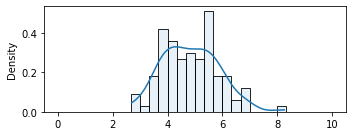

In [2]:
# Example data
true_mean=5
true_std=1
n_samples=100
x = true_mean + true_std * torch.randn(n_samples)# Generate n_samples random noisy data points with mean 5 and standard deviation 1

# Plotting the histogram of the data
plt.figure(figsize=(5, 2))  # Set the figure size
sns.histplot(x, binrange=(0,10), bins=30, kde=True, stat='density', alpha=0.1)  # Plot the histogram with KDE
plt.tight_layout()  # Adjust the layout to fit everything nicely
plt.show()  # Display the plot

Given the observations $x$, estimating a posterior for the mean $\theta$ requires to specify likelihood and prior: 
- As likelihood we choose a Gaussian prior with $\sigma=1$: $p(x|\theta) =  \mathcal{N}(\theta, 1)$.
- As prior we choose a Gaussian $p(\theta) =  \mathcal{N}(0, 1)$.


By applying the Bayes theorem, we need to compute the posterior as:

$$p(\theta \mid x_{1:n}) = \frac{p(x_{1:n} \mid \theta) p(\theta)}{\int p(x_{1:n} \mid \theta) p(\theta) \, d\theta}$$

In the past lesson we have seen how to compute the posterior in close Gaussian form, and how to approximate the posterior with Laplace. 

Here we solve the same problem by using Variational Inference (VI). 
To apply VI we need to choose the family of distributions $\mathcal{Q}$ we want to use to approximate the posterior. We set $\mathcal{Q} = \{q(\theta) \sim \mathcal{N}(\tilde\mu, \tilde\sigma) \mid \tilde\mu \in \mathbb{R}\;\&\;\tilde\sigma \in \mathbb{R}^+\}$. This means we approximate the posterior distribution with a Gaussian distribution. The goal is to find the optimal parameters for this Gaussian distribution.

In [3]:
!pip install graphviz

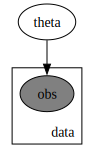

In [4]:
# The model defines the actual posterior by specifying prior and likelihood.
# We need to define how observations are sampled from it.

def model(x):
    # Introduce a prior on the latent variable theta
    theta_prior = dist.Normal(0.0, 1.0)  # Normal prior distribution over theta
    theta = pyro.sample('theta', theta_prior)  # Sample theta from the prior distribution

    # Define the likelihood function; 'pyro.plate' is used to indicate a batch of data points
    with pyro.plate('data', len(x)):
        # Sample the observed data from a Normal distribution with mean theta and standard deviation 1
        pyro.sample('obs', dist.Normal(theta, 1.0), obs=x)
        
pyro.render_model(model, model_args=(x,))

In [5]:
# The guide defines the variational distribution and how observations are sampled from it

def guide(x):
    # Here we create a mu and sigma for the Gaussian variational approximation
    tilde_mu = pyro.param('tilde_mu', torch.randn(1))  # Initialize tilde_mu for the variational distribution
    tilde_sigma = pyro.param('tilde_sigma', torch.exp(torch.randn(1)), constraint=dist.constraints.positive)  # Initialize tilde_sigma for the variational distribution, ensuring positivity

    # Sample z from the variational distribution
    pyro.sample('theta', dist.Normal(tilde_mu, tilde_sigma))
    
  

In [6]:
# At this point we can write an optimization routine as we do in PyTorch

def optimisation(x, n_steps=1000, lr=1e-3):
    # Clear any existing parameters in the Pyro parameter store
    pyro.clear_param_store()

    # Define the optimizer and SVI
    adam_params = {'lr': lr}  # Set learning rate for the Adam optimizer
    optimizer = Adam(adam_params)  # Initialize the Adam optimizer for the optimization of the ELBO
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())  # Initialize SVI with the model, guide, optimizer, and loss function as the ELBO
    
    losses = []  # List to store loss values

    # Perform optimization
    for step in range(n_steps):
        loss = svi.step(x)  # Perform a single optimization step
        
        # Record the loss
        losses.append(loss)  # Append the loss to the list
        
        # Print progress every 500 steps
        if (step + 1) % 500 == 0:
            print(f'Step {step + 1} - Loss: {loss:.2f}')

    return pyro.param('tilde_mu').item(), pyro.param('tilde_sigma').item(), losses

In [7]:
# Perform the optimisation
tilde_mu, tilde_sigma, losses = optimisation(x, n_steps=5000, lr=1e-2)

Step 500 - Loss: 811.07
Step 1000 - Loss: 200.46
Step 1500 - Loss: 157.31
Step 2000 - Loss: 157.22
Step 2500 - Loss: 157.22
Step 3000 - Loss: 157.39
Step 3500 - Loss: 157.68
Step 4000 - Loss: 157.72
Step 4500 - Loss: 158.45
Step 5000 - Loss: 157.87


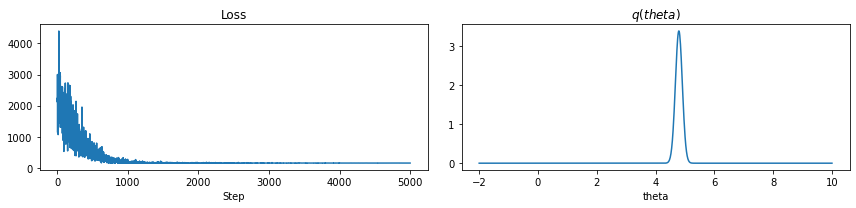

In [15]:
# Plot the solution and the loss over time
fig,ax=plt.subplots(1,2,figsize=(12,3))
plt.sca(ax[0])
plt.plot(losses)
plt.xlabel('Step')
plt.title('Loss')

plt.sca(ax[1])
z=torch.linspace(-2, 10, 1000)
q=scipy.stats.norm.pdf(x=z, loc=tilde_mu, scale=tilde_sigma)
plt.plot(z, q)
plt.xlabel(r'theta')
plt.title(r'$q(theta)$')

plt.tight_layout()
plt.show()

We compare the solution with the Laplace approximation 

In [9]:
%run tools.py

# We specify a likelihood N(\mu, \sigma^2)

# initial values for the parameters mu and sigma2
mu = 0.
sigma = 2.

# Initializing the likelihood
likelihood = 'gaussian'
parameters = [mu, sigma]

# Defining the prior with hyperparameters 
prior_mu_mean = 0
prior_mu_sigma = 1
prior_mu = ['gaussian', [prior_mu_mean, prior_mu_sigma]]

solution = laplace_solution([mu], [1], x, likelihood, [prior_mu])


      fun: 156.60687683725934
 hess_inv: array([[0.00990099]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([4.79485856])


In [10]:
from scipy.stats import gaussian_kde

posterior_samples = multivariate_normal.rvs(solution[0], solution[1], size = 10000)
density = gaussian_kde(posterior_samples)

What about the actual posterior $p(\theta|\mid x_{1:n})$?

In this particular example we can evaluate it analitically: 

$$p(\theta\mid x_{1:n})= \frac{\prod_{i=1}^n \frac{1}{\sqrt{2\pi}}\exp\left(-\frac{1}{2}\left(x_{i}-\theta\right)^2\right)\frac{1}{\sqrt{2\pi}}\exp\left(-\frac{1}{2}\theta^2\right)}{\int \frac{1}{\sqrt{2\pi}\sigma}\prod_{i=1}^n\exp\left(-\frac{1}{2}\left(x_{i}-\theta\right)^2\right) d\theta}\propto \prod_{i=1}^n\exp\left(-\frac{1}{2}\left(x_{i}-\theta\right)^2\right)\exp\left(-\frac{1}{2}\theta^2\right)$$

In [11]:
def log_true_posterior(theta,x):
    return torch.sum(-0.5*torch.square((x-theta)))-0.5*torch.square(theta)

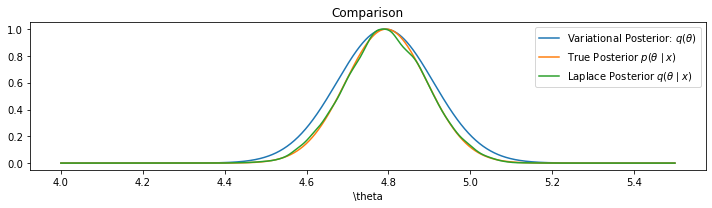

In [14]:
theta=torch.linspace(4, 5.5, 1000)

q=scipy.stats.norm.pdf(x=theta, loc=tilde_mu, scale=tilde_sigma)

log_p=torch.tensor([log_true_posterior(_theta,x) for _theta in theta])
log_p-=log_p.max()

plt.figure(figsize=(10,3))
plt.plot(theta, q/q.max(), label=r'Variational Posterior: $q(\theta)$')
plt.plot(theta,torch.exp(log_p), label=r'True Posterior $p(\theta\mid x)$')
plt.plot(theta, density(theta)/density(theta).max(), label=r'Laplace Posterior $q(\theta\mid x)$')
plt.xlabel(r'\theta')
plt.legend()
plt.title('Comparison')

plt.tight_layout()
plt.show()

# Change of variational posterior

But we are not forced to use Gaussian variational distributions, we can use the faimly of distributions we want. Fore instance we can approximate our model considering $\mathcal{Q} = \{\Gamma(\alpha,\beta) | \alpha \in \mathbb{R}^{+}, \beta\in\mathbb{R}^{+}\}$

In [ ]:
def model(x):
    # Introduce a prior on the latent variable z
    z_prior = dist.Normal(0.0, 1.0)  # Normal prior distribution over z
    z = pyro.sample('z', z_prior)  # Sample z from the prior distribution

    # Define the likelihood function; 'pyro.plate' is used to indicate a batch of data points
    with pyro.plate('data', len(x)):
        # Sample the observed data from a Normal distribution with mean z and standard deviation 1
        pyro.sample('obs', dist.Normal(z, 1.0), obs=x)

def guide(x):
    # Define parameters for the variational distribution
    tilde_alpha = pyro.param('tilde_alpha', torch.exp(torch.randn(1)), constraint=dist.constraints.positive)  # Initialize tilde_alpha for the variational distribution, ensuring positivity
    tilde_beta = pyro.param('tilde_beta', torch.exp(torch.randn(1)), constraint=dist.constraints.positive)  # Initialize tilde_beta for the variational distribution, ensuring positivity

    # Sample z from the variational distribution
    pyro.sample('z', dist.Gamma(tilde_alpha, tilde_beta))

def optimisation(x, n_steps=1000, lr=1e-2):
    # Clear any existing parameters in the Pyro parameter store
    pyro.clear_param_store()

    # Define the optimizer and SVI
    adam_params = {'lr': lr}  # Set learning rate for the Adam optimizer
    optimizer = Adam(adam_params)  # Initialize the Adam optimizer for the optimization of the ELBO
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())  # Initialize SVI with the model, guide, optimizer, and loss function as the ELBO
    
    losses = []  # List to store loss values

    # Perform optimization
    for step in range(n_steps):
        loss = svi.step(x)  # Perform a single optimization step
        
        # Record the loss
        losses.append(loss)  # Append the loss to the list
        
        # Print progress every 500 steps
        if (step + 1) % 500 == 0:
            print(f'Step {step + 1} - Loss: {loss:.2f}')

    return pyro.param('tilde_alpha').item(), pyro.param('tilde_beta').item(), losses

In [ ]:
# Perform the optimisation
tilde_alpha, tilde_beta, losses = optimisation(x, n_steps=10000, lr=1e-3)

In [ ]:
# Plot the solution and the loss over time
fig,ax=plt.subplots(1,2,figsize=(12,3))
plt.sca(ax[0])
plt.plot(losses)
plt.xlabel('Step')
plt.title('Loss')

plt.sca(ax[1])
z=torch.linspace(-2, 10, 1000)
q=scipy.stats.gamma.pdf(x=z, a=tilde_alpha, scale=1/tilde_beta)
plt.plot(z, q)
plt.xlabel(r'z')
plt.title(r'$q(z)$')

plt.tight_layout()
plt.show()

In [ ]:
z=torch.linspace(-2, 10, 1000)

q=scipy.stats.gamma.pdf(x=z, a=tilde_alpha, scale=1/tilde_beta)

log_p=torch.tensor([log_true_posterior(_z,x) for _z in z])
log_p-=log_p.max()

plt.figure(figsize=(10,3))
plt.plot(z, q/q.max(), label=r'Variational Posterior: $q(z)$')
plt.plot(z,torch.exp(log_p), label=r'True Posterior $p(z\mid x)$')
plt.xlabel(r'z')
plt.legend()
plt.title('Comparison')

plt.tight_layout()
plt.show()

# Generalise the code

In [73]:
def model(x):
    # Introduce a prior on the latent variable z
    z_prior = dist.Normal(0.0, 1.0)  # Normal prior distribution over z
    z = pyro.sample('z', z_prior)

    # Define the likelihood function
    with pyro.plate('data', len(x)):
        pyro.sample('obs', dist.Normal(z, 1.0), obs=x)

def guide(x, variational_posterior='Gaussian'):
    if variational_posterior == 'Gaussian':
        tilde_mu = pyro.param('tilde_mu', torch.randn(1) * 10.0)
        tilde_sigma = pyro.param('tilde_sigma', torch.exp(torch.randn(1)), constraint=dist.constraints.positive)
        pyro.sample('z', dist.Normal(tilde_mu, tilde_sigma))

    elif variational_posterior == 'Gamma':
        tilde_alpha = pyro.param('tilde_alpha', torch.exp(torch.randn(1)), constraint=dist.constraints.positive)
        tilde_beta = pyro.param('tilde_beta', torch.exp(torch.randn(1)), constraint=dist.constraints.positive)
        pyro.sample('z', dist.Gamma(tilde_alpha, tilde_beta))

    elif variational_posterior=='Exponential':
        tilde_lambda = pyro.param('tilde_lambda', torch.exp(torch.randn(1)), constraint=dist.constraints.positive)
        pyro.sample('z', dist.Exponential(tilde_lambda))
    else:
        raise ValueError("Unsupported variational posterior. Choose 'Gaussian' or 'Gamma'.")

def optimisation(x, variational_posterior='Gaussian', n_steps=1000, lr=1e-2):
    pyro.clear_param_store()

    optimizer = Adam({'lr': lr})
    svi = SVI(model, lambda x: guide(x, variational_posterior), optimizer, loss=Trace_ELBO())
    
    losses = []

    # Perform optimization with tqdm progress bar
    progress_bar = tqdm.tqdm(range(n_steps), desc="Training", leave=True)
    for step in progress_bar:
        loss = svi.step(x)
        losses.append(loss)
        if (step+1) % 500 == 0: progress_bar.set_postfix(loss=loss)
    
    parameters = {p_name: pyro.param(p_name).item() for p_name in pyro.get_param_store().keys()}
    
    return parameters, losses

def plot_solution(parameters, x, z, variational_posterior=None):

    if variational_posterior=='Gamma':
        q=scipy.stats.gamma.pdf(x=z, a=parameters['tilde_alpha'], scale=1/parameters['tilde_beta'])
    if variational_posterior=='Gaussian':
        q=scipy.stats.norm.pdf(x=z, loc=parameters['tilde_mu'], scale=parameters['tilde_sigma'])
    if variational_posterior=='Exponential':
        q=scipy.stats.expon.pdf(x=z, loc=parameters['tilde_lambda'])


    log_p=torch.tensor([log_true_posterior(_z,x) for _z in z])
    log_p-=log_p.max()
    true_post_p=torch.exp(log_p)

    plt.figure(figsize=(10,3))
    plt.plot(z, q/q.max(), label=r'Variational Posterior: $q(z)$')
    plt.plot(z,true_post_p, label=r'True Posterior $p(z\mid x)$')
    plt.xlabel(r'z')
    plt.legend()
    plt.title('Comparison')

    plt.tight_layout()
    plt.show()

Training: 100%|██████████| 10000/10000 [00:08<00:00, 1206.42it/s, loss=160]


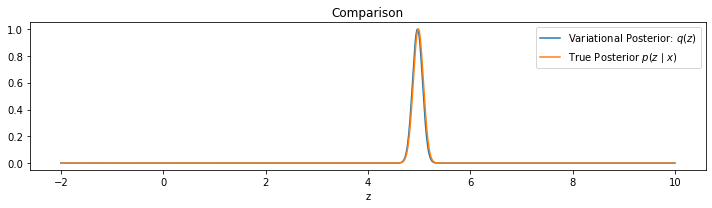

In [74]:
# Perform the optimisation
variational_posterior='Gaussian'
parameters_gaussian, losses_gaussian = optimisation(x, variational_posterior, n_steps=10000, lr=1e-2)
plot_solution(parameters_gaussian, x, z=torch.linspace(-2, 10, 1000), variational_posterior=variational_posterior)

Training: 100%|██████████| 10000/10000 [00:07<00:00, 1258.04it/s, loss=171]


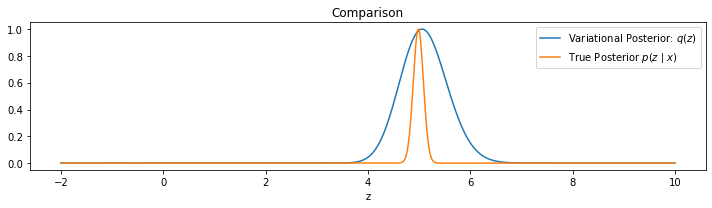

In [75]:
# Perform the optimisation
variational_posterior='Gamma'
parameters_gamma, losses_gamma = optimisation(x, variational_posterior, n_steps=10000, lr=1e-2)
plot_solution(parameters_gamma, x, z=torch.linspace(-2, 10, 1000), variational_posterior=variational_posterior)

Training: 100%|██████████| 10000/10000 [00:11<00:00, 885.00it/s, loss=336]    


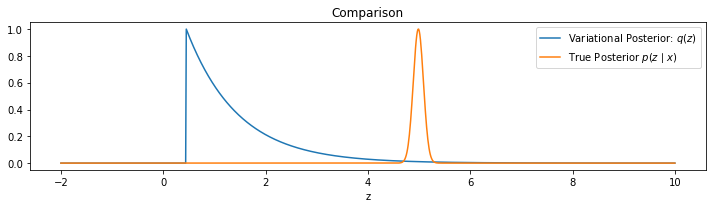

In [76]:
# Perform the optimisation
variational_posterior='Exponential'
parameters_exponential, losses_exponential = optimisation(x, variational_posterior, n_steps=10000, lr=1e-2)
plot_solution(parameters_exponential, x, z=torch.linspace(-2, 10, 1000), variational_posterior=variational_posterior)

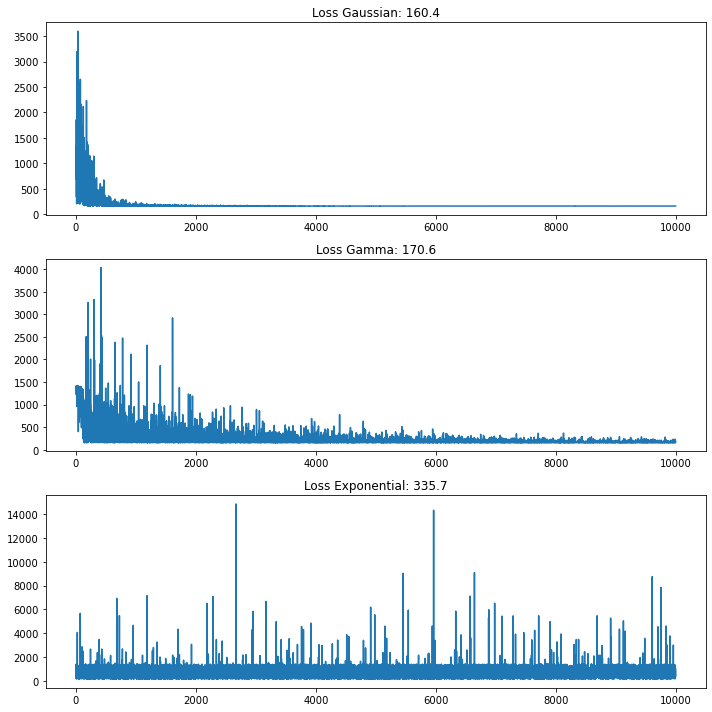

In [77]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
plt.sca(ax[0])
plt.plot(losses_gaussian, alpha=1, label='Gaussian')
plt.title(f'Loss Gaussian: {losses_gaussian[-1]:.1f}')
plt.sca(ax[1])
plt.plot(losses_gamma, alpha=1, label='Gamma')
plt.title(f'Loss Gamma: {losses_gamma[-1]:.1f}')
plt.sca(ax[2])
plt.plot(losses_exponential, alpha=1, label='Exponential')
plt.title(f'Loss Exponential: {losses_exponential[-1]:.1f}')
plt.tight_layout()
plt.show()